<a href="https://colab.research.google.com/github/mdshahilak/ML/blob/main/Fruit_and_vege_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/Fruit_project/fruits_and_vege.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits_and_vege/Validate/Apple 9/145_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/146_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/157_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/158_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/191_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/192_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/203_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/204_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/215_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/216_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/236_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/237_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/251_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/252_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/263_100.jpg  
  inflating: fruits_and_vege/Validate/Apple 9/264

In [4]:
# Import necessary libraries
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Define the number of classes (update based on your dataset)
num_classes = 65

In [7]:
# Load the pre-trained MobileNetV3 Small model
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 15.7MB/s]


In [8]:
# Modify the final layer for the number of classes
mobilenet_v3_small.classifier[3] = nn.Linear(
    mobilenet_v3_small.classifier[3].in_features, num_classes
)
mobilenet_v3_small = mobilenet_v3_small.to(device)

In [9]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# Define paths to datasets
data_dir = "/content/fruits_and_vege"  # Main dataset folder
train_dir = f"{data_dir}/Training"
val_dir = f"{data_dir}/Validate"
test_dir = f"{data_dir}/Test"

In [15]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [16]:
# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_v3_small.parameters(), lr=0.001)

In [19]:
# Training and validation
num_epochs = 10  # You can adjust this
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    # Training phase
    mobilenet_v3_small.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v3_small(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss_history.append(running_train_loss / len(train_loader))

    # Validation phase
    mobilenet_v3_small.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenet_v3_small(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_history.append(running_val_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    val_accuracy_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_history[-1]:.4f}, "
          f"Validation Loss: {val_loss_history[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/10], Train Loss: 0.1335, Validation Loss: 0.0933, Validation Accuracy: 97.13%
Epoch [2/10], Train Loss: 0.0347, Validation Loss: 0.1507, Validation Accuracy: 97.80%
Epoch [3/10], Train Loss: 0.0414, Validation Loss: 0.0043, Validation Accuracy: 99.85%
Epoch [4/10], Train Loss: 0.0037, Validation Loss: 0.0730, Validation Accuracy: 98.27%
Epoch [5/10], Train Loss: 0.0352, Validation Loss: 0.0071, Validation Accuracy: 99.67%
Epoch [6/10], Train Loss: 0.0184, Validation Loss: 0.7268, Validation Accuracy: 85.28%
Epoch [7/10], Train Loss: 0.0172, Validation Loss: 0.0038, Validation Accuracy: 99.93%
Epoch [8/10], Train Loss: 0.0164, Validation Loss: 0.0619, Validation Accuracy: 98.15%
Epoch [9/10], Train Loss: 0.0178, Validation Loss: 0.0135, Validation Accuracy: 99.61%
Epoch [10/10], Train Loss: 0.0173, Validation Loss: 0.1668, Validation Accuracy: 97.65%


In [21]:
# Save the trained model
torch.save(mobilenet_v3_small.state_dict(), "mobilenet_v3_fruits_and_vege.pth")
print("Training complete and model saved!")


Training complete and model saved!


In [22]:
# Evaluate on test data
mobilenet_v3_small.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet_v3_small(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [23]:
# Generate metrics
report = classification_report(y_true, y_pred, target_names=test_dataset.classes, digits=4)
print(report)

                 precision    recall  f1-score   support

          Apple     0.9934    0.9320    0.9617       485
        Apple 1     0.9839    0.9879    0.9859       248
        Apple 2     1.0000    1.0000    1.0000       392
        Apple 3     1.0000    1.0000    1.0000       381
        Apple 4     1.0000    1.0000    1.0000       392
        Apple 5     1.0000    1.0000    1.0000       380
        Apple 6     1.0000    0.9898    0.9949       392
        Apple 7     0.9311    1.0000    0.9643       392
        Apple 8     1.0000    1.0000    1.0000       329
        Apple 9     1.0000    0.7641    0.8663       390
        Avocado     1.0000    1.0000    1.0000       327
         Banana     1.0000    1.0000    1.0000       390
       Banana 1     1.0000    1.0000    1.0000       390
       Banana 2     1.0000    1.0000    1.0000       350
       Beetroot     1.0000    0.9829    0.9914       350
        Brinjal     1.0000    1.0000    1.0000       368
        Cabbage     0.9466    

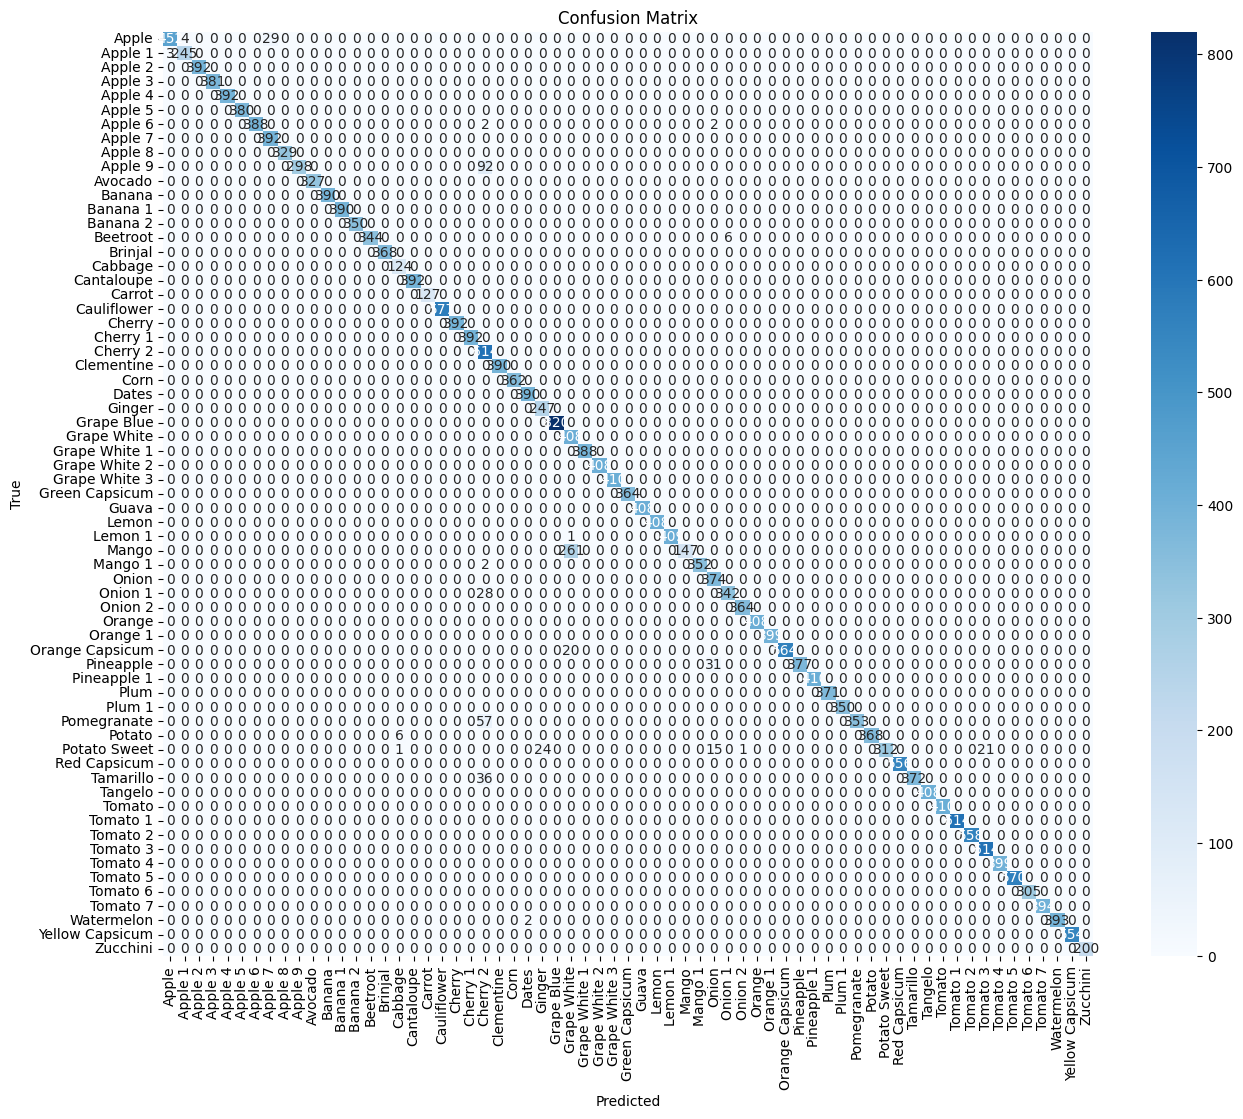

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

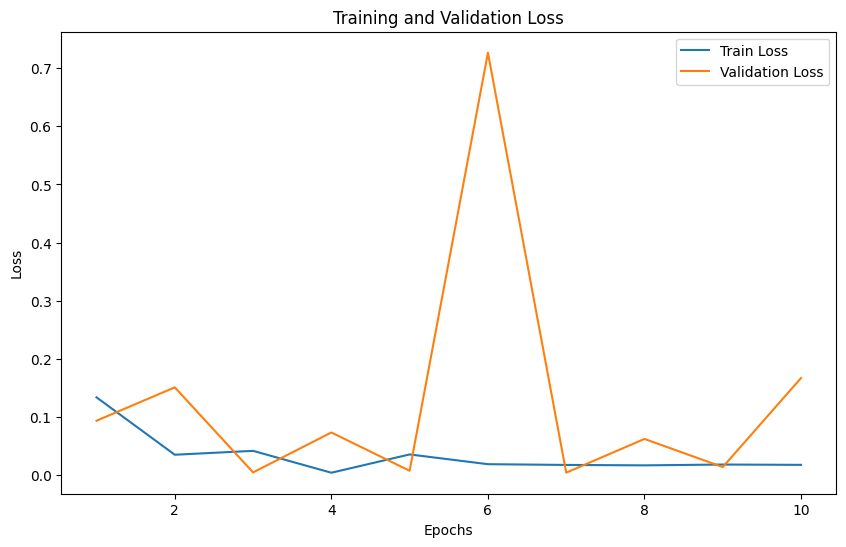

In [25]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

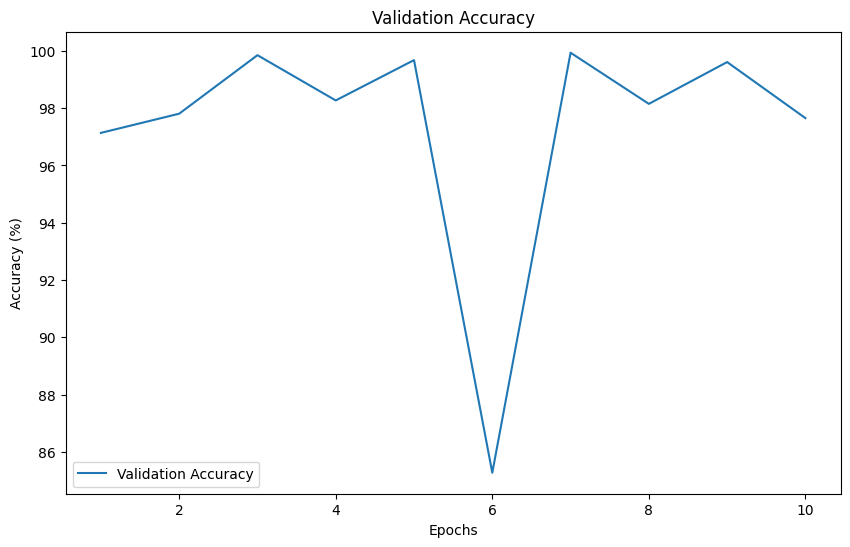

In [26]:
# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()